# Logistic Regression (applied to dummy data)

In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pymc3 as pm
import arviz as az

az.style.use('arviz-darkgrid')

## Load raw data and plot

In [2]:
# read .csv file into Dataframe
data = pd.read_csv('../../data/test/dummy_data.csv')
data

,1200,1300,1400,1500,1600,1700,code,label
0,6.859681,9.472035,15.243682,8.041220,1.359436,0.569499,1,Arabica
1,6.309441,8.401346,15.041552,8.278361,1.028300,1.463044,1,Arabica
2,5.746870,8.223710,16.166272,7.937323,1.125077,1.658064,1,Arabica
3,6.884220,8.235310,16.066599,7.607464,1.831370,0.867443,1,Arabica
4,5.746478,8.615229,15.325160,7.945671,2.605825,1.126482,1,Arabica
5,5.276155,8.619932,8.136409,7.454639,2.973493,1.923625,2,Robusta
6,6.138655,9.805064,9.425262,8.270688,1.467806,0.466879,2,Robusta
7,6.072105,8.877384,8.498315,8.260295,1.528403,0.216872,2,Robusta
8,6.200951,9.619839,9.501848,8.088760,2.424705,1.398675,2,Robusta
9,6.823931,8.042763,9.400266,8.787564,1.583661,0.777459,2,Robusta


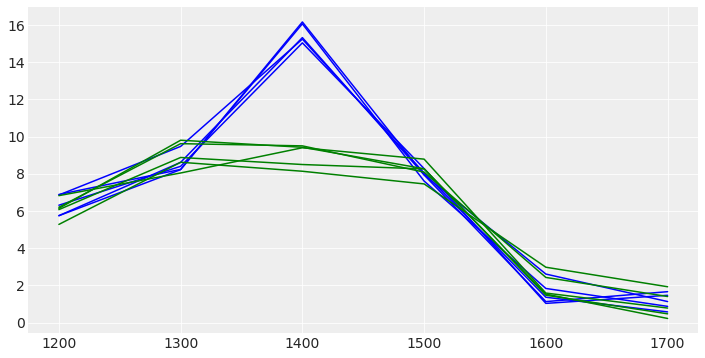

In [28]:
# header data = x-values
cols = data.columns.to_list()
x_val = np.array(cols[:-2], dtype='float32')

# plot all data in 1 figure
fig = plt.figure(figsize=(12,6))
ax = plt.axes()

for i in range(len(data)):
    y_val = data.values[i]
    if y_val[-2] == 1:
        col = 'blue'
    else:
        col = 'green'
    plt.plot(x_val, y_val[:-2], '-', color=col);

In [4]:
# extract X data from dataframe
X = data.iloc[:,:-2].to_numpy()
X.shape

(10, 6)

In [5]:
# extract Y data from dataframe
Y = data.iloc[:,-2].to_numpy()
Y.shape

(10,)

In [6]:
# add a column of ones to X
Xn = np.append(np.ones((X.shape[0],1)), X, axis=1)
Xn.shape

(10, 7)

## Model definition

In [107]:
with pm.Model() as model_mlr:
    beta = pm.Normal('beta', mu=0, sd=0.5, shape=Xn.shape[1])
    epsilon = pm.HalfNormal('epsilon', 10)
    
    mu = pm.math.dot(Xn, beta)

    y_pred = pm.Normal('y_pred', mu=mu, sd=epsilon, observed=Y)

    trace_mlr = pm.sample(2000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [epsilon, beta]
Sampling 2 chains: 100%|███████████████████████████████████████████████████████| 5000/5000 [00:34<00:00, 146.82draws/s]
There were 135 divergences after tuning. Increase `target_accept` or reparameterize.
There were 123 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.


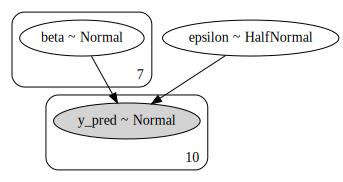

In [108]:
pm.model_to_graphviz(model_mlr)

In [109]:
az.summary(trace_mlr)

,mean,sd,hpd_3%,hpd_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
beta[0],0.153,0.518,-0.842,1.064,0.020,0.015,669.0,618.0,639.0,1188.0,1.00
beta[1],0.093,0.163,-0.225,0.386,0.004,0.004,1575.0,1050.0,1484.0,1718.0,1.00
beta[2],0.076,0.100,-0.108,0.266,0.003,0.002,1438.0,1202.0,1495.0,1603.0,1.00
beta[3],-0.138,0.024,-0.183,-0.089,0.001,0.000,1773.0,1726.0,1705.0,1504.0,1.01
beta[4],0.198,0.148,-0.079,0.476,0.004,0.003,1286.0,1158.0,1256.0,1594.0,1.00
beta[5],0.054,0.122,-0.158,0.315,0.003,0.003,1312.0,1117.0,1308.0,1566.0,1.00
beta[6],0.092,0.148,-0.186,0.369,0.004,0.003,1553.0,1239.0,1505.0,1861.0,1.00
epsilon,0.192,0.088,0.096,0.336,0.003,0.002,704.0,704.0,338.0,127.0,1.01


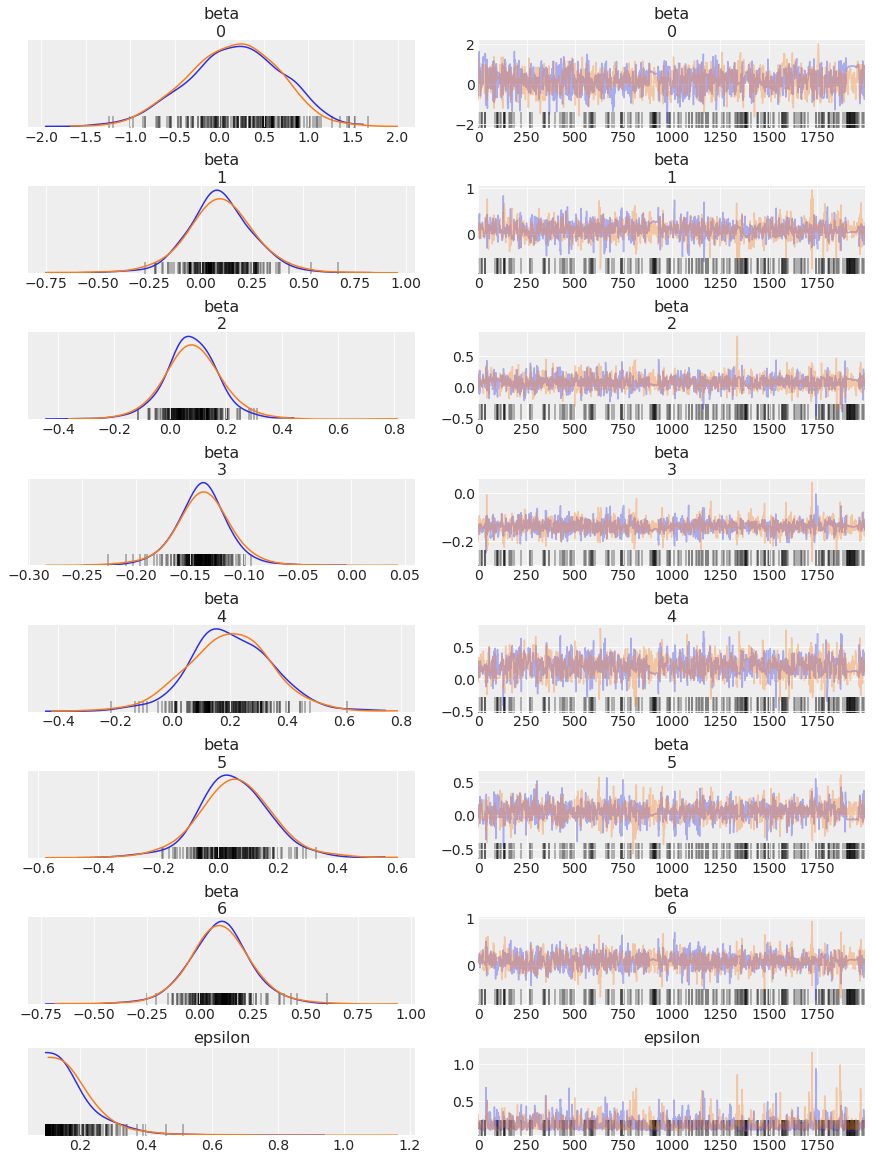

In [110]:
az.plot_trace(trace_mlr);

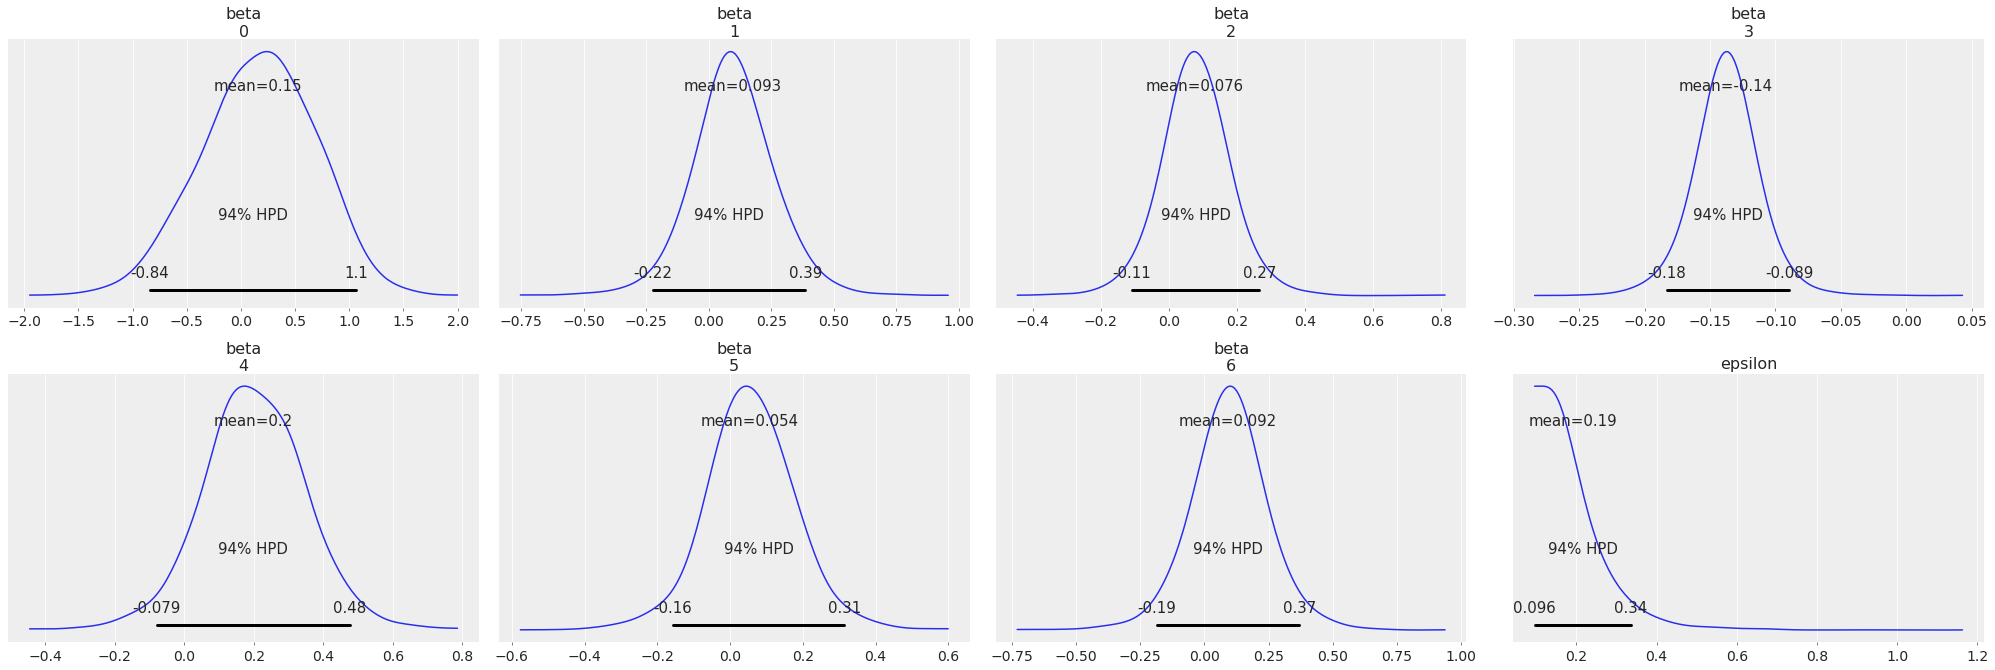

In [111]:
#pm.autocorrplot(trace_mlr);
az.plot_posterior(trace_mlr);

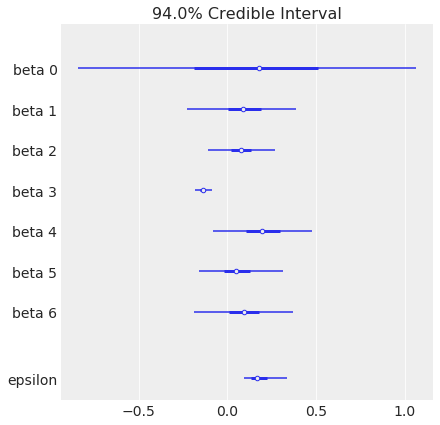

In [112]:
az.plot_forest(trace_mlr, combined=True);

In [113]:
ppc = pm.sample_posterior_predictive(trace_mlr, samples=100, model=model_mlr)

100%|███████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 711.24it/s]


arviz.data.io_pymc3 - WARNING - posterior predictive shape not compatible with number of chains and draws. This can mean that some draws or even whole chains are not represented.


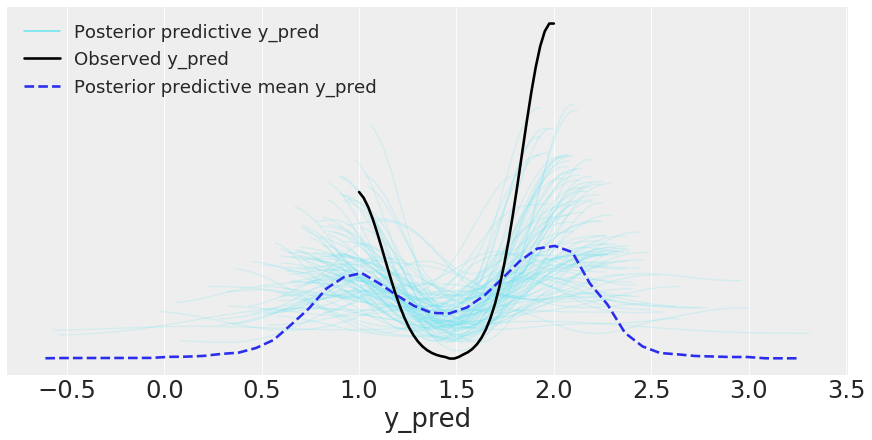

In [114]:
data_ppc = az.from_pymc3(trace=trace_mlr, posterior_predictive=ppc)
ax = az.plot_ppc(data_ppc, figsize=(12, 6), mean=True)